---
## **Matrix Factorization using Deep Network (Recommendation)**
---

[Ref.]
  - https://hackernoon.com/autoencoders-deep-learning-bits-1-11731e200694
  - http://katbailey.github.io/post/matrix-factorization-with-tensorflow/
  - https://www.oreilly.com/ideas/deep-matrix-factorization-using-apache-mxnet
  - http://nicolas-hug.com/blog/matrix_facto_3

<br/>

### **1) Recommendation 방식**



<br/>
- 기본적인 Recommendation의 구조는 아래와 같이 1) 사용자(User) x 2) 아이템(Item) 간의 스코어 matrix 형태로 표현할 수 있음
<br/>
![recomm._mat](recomm._mat.png)
<br/>
- Recommendation을 하기 위해 사용자그룹의 기존(과거) 구매/평점기록 데이터를 활용함
- 그러나 모든 사용자가 모든 아이템에 대한 구매/평점 기록이 없기에 전체 사용자 x 아이템으로 표현되는 Recommendation Matrix는 Sparse & Incomplete한 형태가 됨
- 이 Incomplete Matrix의 Missing Values를 찾는 것이 Recommendation Algorithm의 목적
- 크게 2가지 형태의 Recommendation Algorithm이 있음

  **1) Collaborative Filtering (User-based or Item-based)**
    - 협업필터링 방식으로 추천하고자 하는 대상과 가장 유사한 사용자그룹 혹은 아이템그룹의 유사도와 과거 구매/평점기록을 이용하여 추천하는 방식
    - 그룹 간 유사도를 계산하는 방식으로 Cosine Similarity을 일반적으로 많이 이용함 
    - Missing value에 대한 예측 시 (User or Item) Similairty와 기 존재하는 구매/평점기록값(구매 or 별점)과의 가중평균으로 계산 함
    
    (참조 : https://buildingrecommenders.wordpress.com/2015/11/18/overview-of-recommender-algorithms-part-2/)
    - 1) User-Based CF
        - 추천대상과 유사한 사용자 그룹을 파악하고, 해당 그룹이 많이 사용/구매한 아이템을 추천하는 방식
        - 알고리즘 구현이 간단한 편이지만, 유저가 많아질 수록 연산이 복잡함 (nC2 경우의 수가 많아짐)
    - 2) Item-Based CF
        - 아이템간의 유사도 matrix를 기반으로, 특정 아이템을 추천하는 방식 (가중평균)
        - User-Based CF에 비해 연산이 가벼운 편이지만, 개인 성향을 반영하기 어려움
<br/>
![CF_ex](CF_ex.png)
<br/>

  **2) Matrix Factorization**
    - Sparse & Incomplete Recommendation을 2개 이상의 Low Rank Matrices로 Decomposition하는 방식
    - Decomposition하는 2개의 Matrices는 추천대상(User) / 아이템(Item) Matrix로 나눠 짐
    - 협업 필터링과 달리 사용자(User) / 아이템(Item)의 특성을 표현하는 Latent Factor (:= Embedding values)로 표현함
    [Ex) 2 Dimension Latent Factor으로 표현한 예시]
<br/>
![mat_fact](mat_fact.png)
<br/>
    - Latent Factor로 표현된 2개의 Matrix의 Dot Product가 Recommendation Matrix의 추천 값이 되며, 이 값 중 과거 기록과의 차이를 최소화 하는 Latent Matrix를 찾는 것이 목적
    - Performance Metric으로 RMSE를 주로 사용함
    - 일반적으로 Latent Facotr의 Dimension은 User / Item의 Dimension보다 작은 값을 이용
    - Matrix Factorization 방법으로 PCA / SVD 방법등이 있지만, Sparse & Incomplete Matrix이기에 Latent Matrices에 초기값을 주고 Iteration 마다 최적값을 찾아가는 Optimization 방법을 주로 이용
    - 본 스터디에서는 Optimization 방법 중 Deep Learning Framework를 이용한 Vanila Matrix Factorization 방법과 Deep Matrix Facotrization 방법을 소개 함

 <br/>
- **Deep Matrix Factorization의 장점**
    - Flatten Layer를 사용하기 때문에 Embedding Layer의 Latent Dimension의 크기를 다르게 가져갈 수 있음 (Ex. User는 10차원, Item은 5차원)
    - Vanilla Matrix Factorization은 User간 or Item간의 Inter-connection의 영향을 반영하기 어렵지만, Flatten으로 펼쳐서 학습하기 떄문에 User간, Item간, User-Item간의 Inter-connection을 학습할 수 있음
    - Vanilla Matrix Factorization에서 불가능한 non-linear connections을 표현 가능
    - Latent Factor를 표현하는 Embedding Layer를 2개 이상 할 수 있음 (Flatten 함수 써서)
    - Dot Product가 없기에 학습속도가 훨씬 빠름

 <br/>

In [1]:
%pylab inline
import mxnet as mx
import pandas
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Gluon module load
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn

ctx = mx.cpu()

---
### **1) Vanila Matrix Facotrization using synthetic data**
---

- 2개의 low rank latent matrix의 dot product로 예측하는 일반적인 Matrix Facotrization 방법
- 2개의 latent matrix rank는 같음
- rank <= input dimension

Synthetic data set is generated. [row num : 35000]


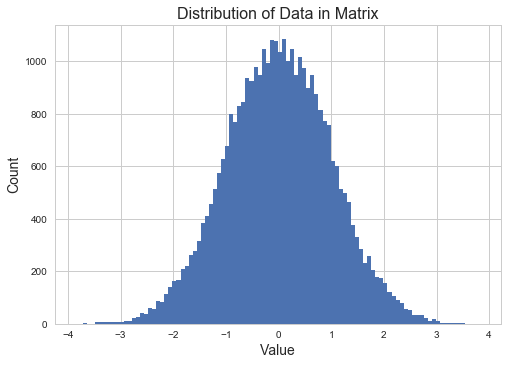

It appears to be a normal distribution that is centered around 0 with a variance of 1


In [3]:
## Generate random synthetic data set (250 users x 250 movies)
X = numpy.random.randn(250, 250) # 250x250 = 62,500 complete data set (no missing values)

# extract subset of data (Assume this is only given data)
n = 35000
i = numpy.random.randint(250, size=n) # Generate random row indexes
j = numpy.random.randint(250, size=n) # Generate random column indexes
X_values = X[i, j]
print("Synthetic data set is generated. [row num : {}]".format(X_values.shape[0]))

# distribution of extracted values
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

print('It appears to be a normal distribution that is centered around 0 with a variance of 1')

In [4]:
## Make Vanila Matrix Factorization(MF) using Gluon hybrid-block 
class Vanilla_MF(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Vanilla_MF, self).__init__(**kwargs)
        with self.name_scope():
            self.user = nn.Embedding(input_dim=250, output_dim=25) # Embedding Layer for Users (25 latent factors)
            self.movie = nn.Embedding(input_dim=250, output_dim=25) # Embedding Layer for Movies (25 latent factors)
#             self.dense = nn.Dense(1)
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        z = F.sum(F.multiply(user_i, movie_i), axis = 1) # element-wise multiplication of users x movies and rowwise sum of result
#         z = self.dense(z) # To add bias of user and movies, we made the 1 node dense-layer to make a resule of the linear regression form
        return z

In [5]:
# model initialization
model = Vanilla_MF()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

learning_rate = 1e-4
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [6]:
# Embedding layer latent factors
user_latent_v = model.user.weight.data().asnumpy()
print("User embedding layer shape : {}\n".format(user_latent_v.shape))
item_latent_v = model.movie.weight.data().asnumpy()
print("Item embedding layer shape : {}\n".format(item_latent_v.shape))

print("25 Embedding latents factors of the first user : \n{}".format(user_latent_v[0]))

User embedding layer shape : (250, 25)

Item embedding layer shape : (250, 25)

25 Embedding latents factors of the first user : 
[ 0.08690061  0.11293826 -0.10049446  0.12735233 -0.03226358  0.10438174
  0.12894627 -0.00171298  0.04623531 -0.14136802  0.01747404  0.06442726
  0.05782974 -0.0706878  -0.11482002 -0.03529139 -0.03970727 -0.08992843
  0.09868617  0.060701   -0.09062057 -0.02898844  0.10589617  0.02242789
 -0.11005463]


In [7]:
# User rating sample by dot product of user x item embedding matrix
user_i = 1
movie_i = 2

# naive dot product example
user_v = user_latent_v[user_i]
movie_v = item_latent_v[movie_i]
print("Dot product of {}th user and {}th movie : {:.4f}".format(user_i, movie_i, np.dot(user_v,movie_v)))

# dot product using gluon network 
user_n = mx.nd.array([user_i])
item_n = mx.nd.array([movie_i])
print("Model result of {}th user and {}th movie : {:.4f}".format(user_i, movie_i, model(user_n, item_n).asnumpy()[0]))

Dot product of 1th user and 2th movie : -0.0330
Model result of 1th user and 2th movie : -0.0330


In [8]:
# Make batch input using gluon DataLoader
batch_size = 10000
X_train = gluon.data.DataLoader(gluon.data.ArrayDataset(i[:25000].astype('float32'), j[:25000].astype('float32'), X_values[:25000].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

X_eval = gluon.data.DataLoader(gluon.data.ArrayDataset(i[25000:].astype('float32'), j[25000:].astype('float32'), X_values[25000:].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

In [30]:
# Epoch Running Function
def run_epoch(model, X_train, X_eval, num_epochs = 20):
    for epoch in range(num_epochs):
        running_loss = 0.0
        val_loss = 0.0
        n_total = 0.0

        # for training
        for user, movie, rating in X_train:
            user = user.as_in_context(ctx)
            movie = movie.as_in_context(ctx)
            rating = rating.as_in_context(ctx)

            with mx.autograd.record():
                output = model(user, movie)
                loss = criterion(output, rating)
            loss.backward()
            optimizer.step(user.shape[0])
            running_loss += mx.nd.sum(loss).asscalar()
            n_total += user.shape[0]

        for val_user, val_movie, val_rating in X_eval:
            val_user = val_user.as_in_context(ctx)
            val_movie = val_movie.as_in_context(ctx)

            with mx.autograd.record():
                val_output = model(val_user, val_movie)
                val_loss_tmp = criterion(val_output, val_rating)
            val_loss += mx.nd.sum(val_loss_tmp).asscalar()

        # ===================log========================
        if num_epochs >= 100:
            if epoch%10 == 0 or epoch == (num_epochs-1):
                print('epoch [{}/{}], (rmse) loss:{:.4f}, (rmse) val_loss:{:.4f}'.format(epoch + 1, num_epochs, np.sqrt(running_loss / n_total), np.sqrt(val_loss / n_total)))
        else:
            print('epoch [{}/{}], (rmse) loss:{:.4f}, (rmse) val_loss:{:.4f}'.format(epoch + 1, num_epochs, np.sqrt(running_loss / n_total), np.sqrt(val_loss / n_total)))
    return model

In [10]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 20)

epoch [1/20], (rmse) loss:0.7017, (rmse) val_loss:0.4493
epoch [2/20], (rmse) loss:0.7016, (rmse) val_loss:0.4493
epoch [3/20], (rmse) loss:0.7015, (rmse) val_loss:0.4493
epoch [4/20], (rmse) loss:0.7015, (rmse) val_loss:0.4493
epoch [5/20], (rmse) loss:0.7014, (rmse) val_loss:0.4493
epoch [6/20], (rmse) loss:0.7014, (rmse) val_loss:0.4493
epoch [7/20], (rmse) loss:0.7013, (rmse) val_loss:0.4493
epoch [8/20], (rmse) loss:0.7013, (rmse) val_loss:0.4492
epoch [9/20], (rmse) loss:0.7012, (rmse) val_loss:0.4492
epoch [10/20], (rmse) loss:0.7012, (rmse) val_loss:0.4492
epoch [11/20], (rmse) loss:0.7011, (rmse) val_loss:0.4492
epoch [12/20], (rmse) loss:0.7010, (rmse) val_loss:0.4492
epoch [13/20], (rmse) loss:0.7010, (rmse) val_loss:0.4492
epoch [14/20], (rmse) loss:0.7009, (rmse) val_loss:0.4492
epoch [15/20], (rmse) loss:0.7009, (rmse) val_loss:0.4492
epoch [16/20], (rmse) loss:0.7008, (rmse) val_loss:0.4492
epoch [17/20], (rmse) loss:0.7008, (rmse) val_loss:0.4492
epoch [18/20], (rmse) l

#### Problem of the totally and randomly generated data set : no strong connections(dependencies) between two latent matrices
- If there does not exist connections(dependencies) between two latent matrices, the performance of Vanilla MF does not seem to get increased well. 
- And this is because we generated the data using total random normal. 
- It is like  he "movie watchers" don't have any preferences, they just randomly like or don't like movies! It would be impossible to predict

Synthetic data set is generated. [row num : 35000]


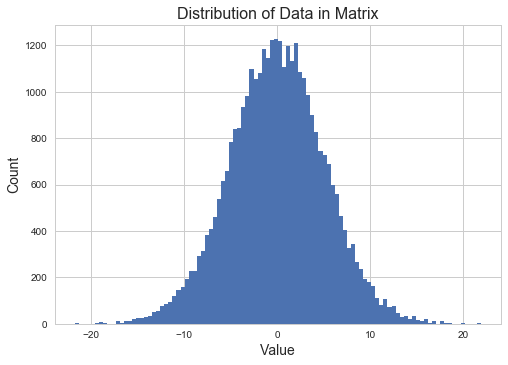

It appears to be a normal distribution that is centered around 0 but lager variance than original synthetic data set


In [11]:
## Generate synthetic data set using two row rank latent matrix (randomly generated) 
### -> It essentially makes the connections between latents matrix
a = numpy.random.normal(0, 1, size=(250, 25)) # Generate random numbers for the first skinny matrix
b = numpy.random.normal(0, 1, size=(25, 250)) # Generate random numbers for the second skinny matrix

X = a.dot(b) # Build our real data matrix from the dot product of the two skinny matrices

n = 35000
i = numpy.random.randint(250, size=n)
j = numpy.random.randint(250, size=n)
X_values = X[i, j]
print("Synthetic data set is generated. [row num : {}]".format(X_values.shape[0]))

# distribution of extracted values
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

print('It appears to be a normal distribution that is centered around 0 but lager variance than original synthetic data set')

In [12]:
batch_size = 10000
X_train = gluon.data.DataLoader(gluon.data.ArrayDataset(i[:25000].astype('float32'), j[:25000].astype('float32'), X_values[:25000].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

X_eval = gluon.data.DataLoader(gluon.data.ArrayDataset(i[25000:].astype('float32'), j[25000:].astype('float32'), X_values[25000:].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

In [13]:
# model initialization
model = Vanilla_MF()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

learning_rate = 1e-4
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [14]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 20)

epoch [1/20], (rmse) loss:3.6142, (rmse) val_loss:2.2995
epoch [2/20], (rmse) loss:3.6141, (rmse) val_loss:2.2995
epoch [3/20], (rmse) loss:3.6140, (rmse) val_loss:2.2995
epoch [4/20], (rmse) loss:3.6140, (rmse) val_loss:2.2994
epoch [5/20], (rmse) loss:3.6139, (rmse) val_loss:2.2994
epoch [6/20], (rmse) loss:3.6139, (rmse) val_loss:2.2994
epoch [7/20], (rmse) loss:3.6138, (rmse) val_loss:2.2994
epoch [8/20], (rmse) loss:3.6138, (rmse) val_loss:2.2994
epoch [9/20], (rmse) loss:3.6137, (rmse) val_loss:2.2994
epoch [10/20], (rmse) loss:3.6136, (rmse) val_loss:2.2994
epoch [11/20], (rmse) loss:3.6136, (rmse) val_loss:2.2994
epoch [12/20], (rmse) loss:3.6135, (rmse) val_loss:2.2994
epoch [13/20], (rmse) loss:3.6135, (rmse) val_loss:2.2993
epoch [14/20], (rmse) loss:3.6134, (rmse) val_loss:2.2993
epoch [15/20], (rmse) loss:3.6134, (rmse) val_loss:2.2993
epoch [16/20], (rmse) loss:3.6133, (rmse) val_loss:2.2993
epoch [17/20], (rmse) loss:3.6133, (rmse) val_loss:2.2993
epoch [18/20], (rmse) l

In [15]:
## Make Vanila Matrix Factorization(MF) using Gluon hybrid-block 
class Vanilla_MF_w_bias(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Vanilla_MF_w_bias, self).__init__(**kwargs)
        with self.name_scope():
            self.user = nn.Embedding(input_dim=250, output_dim=25) # Embedding Layer for Users (25 latent factors)
            self.movie = nn.Embedding(input_dim=250, output_dim=25) # Embedding Layer for Movies (25 latent factors)
            self.dense = nn.Dense(1)
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        z = F.sum(F.multiply(user_i, movie_i), axis = 1) # element-wise multiplication of users x movies and rowwise sum of result
        z = self.dense(z) # To add bias of user and movies, we made the 1 node dense-layer to make a resule of the linear regression form
        return z

In [16]:
# model initialization
model = Vanilla_MF_w_bias()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

learning_rate = 1e-4
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [28]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 20)

epoch [1/20], (rmse) loss:0.7291, (rmse) val_loss:1.8373
epoch [2/20], (rmse) loss:0.7279, (rmse) val_loss:1.8396
epoch [3/20], (rmse) loss:0.7245, (rmse) val_loss:1.8385
epoch [4/20], (rmse) loss:0.7231, (rmse) val_loss:1.8416
epoch [5/20], (rmse) loss:0.7252, (rmse) val_loss:1.8394
epoch [6/20], (rmse) loss:0.7199, (rmse) val_loss:1.8370
epoch [7/20], (rmse) loss:0.7197, (rmse) val_loss:1.8424
epoch [8/20], (rmse) loss:0.7214, (rmse) val_loss:1.8384
epoch [9/20], (rmse) loss:0.7174, (rmse) val_loss:1.8412
epoch [10/20], (rmse) loss:0.7201, (rmse) val_loss:1.8428
epoch [11/20], (rmse) loss:0.7193, (rmse) val_loss:1.8384
epoch [12/20], (rmse) loss:0.7154, (rmse) val_loss:1.8400
epoch [13/20], (rmse) loss:0.7157, (rmse) val_loss:1.8430
epoch [14/20], (rmse) loss:0.7152, (rmse) val_loss:1.8422
epoch [15/20], (rmse) loss:0.7176, (rmse) val_loss:1.8420
epoch [16/20], (rmse) loss:0.7114, (rmse) val_loss:1.8422
epoch [17/20], (rmse) loss:0.7131, (rmse) val_loss:1.8400
epoch [18/20], (rmse) l

---
### **2) Deep matrix Facotrization using synthetic data**
---

- 기존 two latent matrix의 dot product 곱의 형태가 아닌 방식
- Two latent layer(matrix)를 concat 후 Flatten하는 방식 사용
- 이후 Regression 형태[0,1]의 결과값을 얻기 위해 Fully Connected Layer를 사용하여 Output 산출

<br/>
<img src="deep_mf.png" width="700">
<br/>


In [24]:
class Deep_MF(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Deep_MF, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=250, output_dim=25)
            self.movie = nn.Embedding(input_dim=250, output_dim=25)
            
            
            self.out = gluon.nn.HybridSequential('output_')
            with self.out.name_scope(): # Output layers to make regression result
                self.out.add(nn.Flatten())
                self.out.add(nn.Dense(64, activation='relu'))
                self.out.add(nn.Dense(1)) # the last output layer
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        
        z = F.concat(user_i, movie_i) # Two latent layer(matrix) concat
        z = self.out(z) # concat output -> flatten -> dense layer(64 dim) -> output layer(1 dim)
        return z

In [25]:
# model initialization
model = Deep_MF()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

learning_rate = 1e-2 # 기존 Vanilla 모형에 비해 running 속도가 빠름, 그러나 학습속도가 느리기에 learning_rate를 높임
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [31]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 500)

epoch [1/500], (rmse) loss:0.6104, (rmse) val_loss:1.9029
epoch [11/500], (rmse) loss:0.6119, (rmse) val_loss:1.9039
epoch [21/500], (rmse) loss:0.6064, (rmse) val_loss:1.9059
epoch [31/500], (rmse) loss:0.6101, (rmse) val_loss:1.9073
epoch [41/500], (rmse) loss:0.6179, (rmse) val_loss:1.9057
epoch [51/500], (rmse) loss:0.6118, (rmse) val_loss:1.9080
epoch [61/500], (rmse) loss:0.6119, (rmse) val_loss:1.9068
epoch [71/500], (rmse) loss:0.6083, (rmse) val_loss:1.9103
epoch [81/500], (rmse) loss:0.6012, (rmse) val_loss:1.9085
epoch [91/500], (rmse) loss:0.6021, (rmse) val_loss:1.9115
epoch [101/500], (rmse) loss:0.5995, (rmse) val_loss:1.9113
epoch [111/500], (rmse) loss:0.6022, (rmse) val_loss:1.9133
epoch [121/500], (rmse) loss:0.6109, (rmse) val_loss:1.9173
epoch [131/500], (rmse) loss:0.5984, (rmse) val_loss:1.9156
epoch [141/500], (rmse) loss:0.6017, (rmse) val_loss:1.9154
epoch [151/500], (rmse) loss:0.6015, (rmse) val_loss:1.9186
epoch [161/500], (rmse) loss:0.6031, (rmse) val_los

- We can see that while the neural network is clearly training due to the validation mse decreasing after each epoch, it is not decreasing as quickly as normal matrix factorization.

---
## Movielens 0.1M
---

- Randomly Generated Data가 아닌 실제 데이터를 활용함
- Recommendation계의 MNIST 데이터로 Movielnes Data Set을 활용

(참고 : https://grouplens.org/datasets/movielens/)

In [40]:
import os
import zipfile
import pandas as pd

os.getcwd()

'/Users/Juyeong/Documents/gluon_study/Recommendation'

In [41]:
# Now extract the data since we know we have it at this point
with zipfile.ZipFile("ml-latest-small.zip", "r") as f:
    f.extractall("./")

# Now load it up using a pandas dataframe
data = pandas.read_csv('./ml-latest-small/ratings.csv', sep=',', usecols=(0, 1, 2))
data.head()
# ratings from 0.5 to 5. by 0.5 inc
len(data)

#Since only ~20M of these are present, ~99.5% of the matrix is missing

100004

In [42]:
print("Min value of rating : {}".format(data.rating.min(axis=0)))
print("Max value of rating : {}".format(data.rating.max(axis=0)))

Min value of rating : 0.5
Max value of rating : 5.0


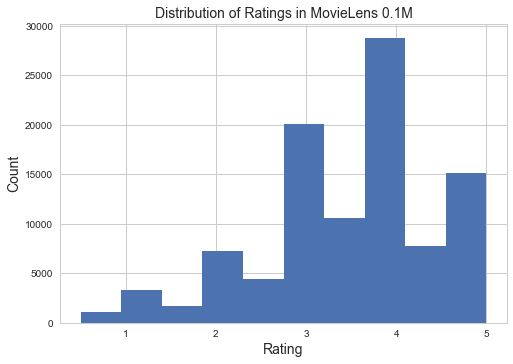

In [43]:
plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in MovieLens 0.1M", fontsize=14)
plt.show()

In [47]:
data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


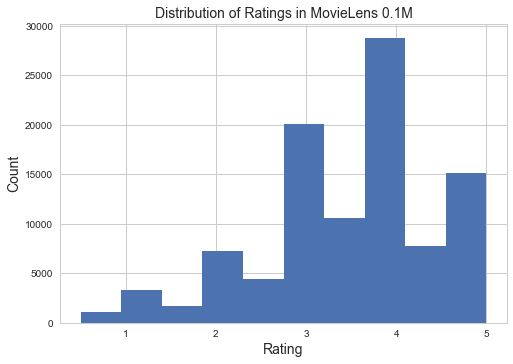

In [48]:
plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in MovieLens 0.1M", fontsize=14)
plt.show()

In [49]:
print("user id min/max: ", data['userId'].min(), data['userId'].max())
print("# unique users: ", numpy.unique(data['userId']).shape[0])
print("")
print("movie id min/max: ", data['movieId'].min(), data['movieId'].max())
print("# unique movies: ", numpy.unique(data['movieId']).shape[0])

user id min/max:  1 671
# unique users:  671

movie id min/max:  1 163949
# unique movies:  9066


In [50]:
data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [51]:
## 불필요한 movie ID를 제거하고, mapping table 생성(0번부터)
# Movie ID mapping 자료 생성
unique_movie_id = pd.DataFrame(data['movieId'].unique(), columns=['movieId']).sort_values(by = ['movieId']).reset_index(drop=True)
movie_ind = pd.DataFrame(np.arange(0,numpy.unique(data['movieId']).shape[0]), columns=['movieId_ind'])
movie_ind_map = pd.concat([movie_ind, unique_movie_id], axis = 1)
print(movie_ind_map.tail())

# User ID mapping 자료 생성
unique_user_id = pd.DataFrame(data['userId'].unique(), columns=['userId']).sort_values(by = ['userId']).reset_index(drop=True)
user_ind = pd.DataFrame(np.arange(0,numpy.unique(data['userId']).shape[0]), columns=['userId_ind'])
user_ind_map = pd.concat([user_ind, unique_user_id], axis = 1)
print(user_ind_map.tail())

      movieId_ind  movieId
9061         9061   161944
9062         9062   162376
9063         9063   162542
9064         9064   162672
9065         9065   163949
     userId_ind  userId
666         666     667
667         667     668
668         668     669
669         669     670
670         670     671


In [52]:
## 원 데이터에 mapping index 추가
data_map = pd.merge(data, user_ind_map, on = 'userId')
data_map = pd.merge(data_map, movie_ind_map, on = 'movieId')
print(data_map.head())

   userId  movieId  rating  userId_ind  movieId_ind
0       1       31     2.5           0           30
1       7       31     3.0           6           30
2      31       31     4.0          30           30
3      32       31     4.0          31           30
4      36       31     3.0          35           30


In [53]:
# find the size of embeddling layers input
n_users, n_movies = numpy.unique(data_map['userId']).shape[0], numpy.unique(data_map['movieId']).shape[0]
batch_size = 15000

In [54]:
# Train & Validation Set 생성
n = 90000

data_map = data_map.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

#  train the model
train_users = data_map['userId_ind'].values[:n]
train_movies = data_map['movieId_ind'].values[:n]
train_ratings = data_map['rating'].values[:n]

# validation of the model
valid_users = data_map['userId_ind'].values[n:]
valid_movies = data_map['movieId_ind'].values[n:]
valid_ratings = data_map['rating'].values[n:]

In [55]:
X_train = gluon.data.DataLoader(gluon.data.ArrayDataset(train_users.astype('float32'), train_movies.astype('float32'), train_ratings.astype('float32')),
                                      batch_size=batch_size, shuffle=True)

X_eval = gluon.data.DataLoader(gluon.data.ArrayDataset(valid_users.astype('float32'), valid_movies.astype('float32'), valid_ratings.astype('float32')),
                                      batch_size=batch_size, shuffle=True)

In [79]:
class Vanilla_MF_ml(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Vanilla_MF_ml, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=n_users, output_dim=25)
            self.movie = nn.Embedding(input_dim=n_movies, output_dim=25)
            self.flat = nn.Flatten()
            self.dense = nn.Dense(1)
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        z = F.sum(F.multiply(user_i, movie_i), axis = 1)
        z = self.flat(z)
        z = self.dense(z)
        return z

In [80]:
# model initialization
model = Vanilla_MF_ml()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)


learning_rate = 1e-4
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [81]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 20)

epoch [1/20], (rmse) loss:2.6158, (rmse) val_loss:0.8690
epoch [2/20], (rmse) loss:2.6153, (rmse) val_loss:0.8689
epoch [3/20], (rmse) loss:2.6148, (rmse) val_loss:0.8687
epoch [4/20], (rmse) loss:2.6143, (rmse) val_loss:0.8686
epoch [5/20], (rmse) loss:2.6138, (rmse) val_loss:0.8685
epoch [6/20], (rmse) loss:2.6133, (rmse) val_loss:0.8683
epoch [7/20], (rmse) loss:2.6128, (rmse) val_loss:0.8682
epoch [8/20], (rmse) loss:2.6123, (rmse) val_loss:0.8681
epoch [9/20], (rmse) loss:2.6118, (rmse) val_loss:0.8679
epoch [10/20], (rmse) loss:2.6113, (rmse) val_loss:0.8678
epoch [11/20], (rmse) loss:2.6108, (rmse) val_loss:0.8676
epoch [12/20], (rmse) loss:2.6103, (rmse) val_loss:0.8675
epoch [13/20], (rmse) loss:2.6098, (rmse) val_loss:0.8674
epoch [14/20], (rmse) loss:2.6093, (rmse) val_loss:0.8672
epoch [15/20], (rmse) loss:2.6088, (rmse) val_loss:0.8671
epoch [16/20], (rmse) loss:2.6082, (rmse) val_loss:0.8669
epoch [17/20], (rmse) loss:2.6077, (rmse) val_loss:0.8668
epoch [18/20], (rmse) l

In [82]:
class Deep_MF_ml(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Deep_MF_ml, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=n_users, output_dim=25)
            self.movie = nn.Embedding(input_dim=n_movies, output_dim=25)
            
            
            self.out = gluon.nn.HybridSequential('output_')
            with self.out.name_scope():
                self.out.add(nn.Flatten())
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(1)) # encoding & latent layer
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        
        z = F.concat(user_i, movie_i)
        z = self.out(z)
        return z

In [83]:
# model initialization
model = Deep_MF_ml()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)


learning_rate = 1e-2
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [84]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 100)

epoch [1/100], (rmse) loss:2.5074, (rmse) val_loss:0.7241
epoch [11/100], (rmse) loss:0.3969, (rmse) val_loss:0.2382
epoch [21/100], (rmse) loss:0.3107, (rmse) val_loss:0.2491
epoch [31/100], (rmse) loss:0.2828, (rmse) val_loss:0.2576
epoch [41/100], (rmse) loss:0.2657, (rmse) val_loss:0.2611
epoch [51/100], (rmse) loss:0.2565, (rmse) val_loss:0.2639
epoch [61/100], (rmse) loss:0.2399, (rmse) val_loss:0.2665
epoch [71/100], (rmse) loss:0.2285, (rmse) val_loss:0.2675
epoch [81/100], (rmse) loss:0.2309, (rmse) val_loss:0.2684
epoch [91/100], (rmse) loss:0.2125, (rmse) val_loss:0.2719
epoch [100/100], (rmse) loss:0.2212, (rmse) val_loss:0.2718


In [85]:
# Regression 형태가 아닌 Classification 문제로 변환
# movielens의 경우 0.5 ~ 5까지 0.5구간으로 평점이 존재하며 이에 따라 총 10개의 class인 문제로 표현 가능
class Deep_MF_ml_class(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Deep_MF_ml_class, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=n_users, output_dim=25)
            self.movie = nn.Embedding(input_dim=n_movies, output_dim=25)
            
            
            self.out = gluon.nn.HybridSequential('output_')
            with self.out.name_scope():
                self.out.add(nn.Flatten())
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(10)) # encoding & latent layer
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        
        z = F.concat(user_i, movie_i)
        z = self.out(z)
        return z

In [86]:
# model initialization
model2 = Deep_MF_ml_class()
model2.collect_params().initialize(mx.init.Xavier(), ctx=ctx)


learning_rate = 1e-3
criterion = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = gluon.Trainer(model2.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [87]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    
    for user, movie, rating in data_iterator:
        user = user.as_in_context(ctx)
        movie = movie.as_in_context(ctx)
        rating = rating.as_in_context(ctx)
    
        output = net(user, movie)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=rating)
    return acc.get()[1]

In [88]:
num_epochs = 100             
              
for epoch in range(num_epochs):
    running_loss = 0.0
    val_loss = 0.0
    n_total = 0.0

    # for training
    for user, movie, rating in X_train:
        user = user.as_in_context(ctx)
        movie = movie.as_in_context(ctx)
        rating = rating.as_in_context(ctx)

        with mx.autograd.record():
            output = model2(user, movie)
            loss = criterion(output, rating)
        loss.backward()
        optimizer.step(user.shape[0])
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += user.shape[0]

    for val_user, val_movie, val_rating in X_eval:
        val_user = val_user.as_in_context(ctx)
        val_movie = val_movie.as_in_context(ctx)

        with mx.autograd.record():
            val_output = model2(val_user, val_movie)
            val_loss_tmp = criterion(val_output, val_rating)
        val_loss += mx.nd.sum(val_loss_tmp).asscalar()
    
    train_accuracy = evaluate_accuracy(X_train, model2)
    test_accuracy = evaluate_accuracy(X_eval, model2)
    # ===================log========================
    if epoch%10 == 0 or epoch == num_epochs -1 :
        print('epoch [{}/{}], loss:{:.4f}, val_loss:{:.4f}, train_acc:{:.4f}, val_acc:{:.4f}'
          .format(epoch + 1, num_epochs, np.sqrt(running_loss / n_total), np.sqrt(val_loss / n_total), train_accuracy, test_accuracy))

epoch [1/100], loss:1.6389, val_loss:0.5239, train_acc:0.0499, val_acc:0.0518
epoch [11/100], loss:1.1402, val_loss:0.4610, train_acc:0.5256, val_acc:0.3772
epoch [21/100], loss:0.8980, val_loss:0.4781, train_acc:0.7448, val_acc:0.4085
epoch [31/100], loss:0.7833, val_loss:0.5053, train_acc:0.8015, val_acc:0.3970
epoch [41/100], loss:0.7196, val_loss:0.5283, train_acc:0.8336, val_acc:0.3934
epoch [51/100], loss:0.6761, val_loss:0.5467, train_acc:0.8521, val_acc:0.3907
epoch [61/100], loss:0.6429, val_loss:0.5629, train_acc:0.8685, val_acc:0.3907
epoch [71/100], loss:0.6169, val_loss:0.5779, train_acc:0.8802, val_acc:0.3881
epoch [81/100], loss:0.5934, val_loss:0.5914, train_acc:0.8907, val_acc:0.3843
epoch [91/100], loss:0.5743, val_loss:0.6046, train_acc:0.8979, val_acc:0.3859
epoch [100/100], loss:0.5593, val_loss:0.6153, train_acc:0.9034, val_acc:0.3826


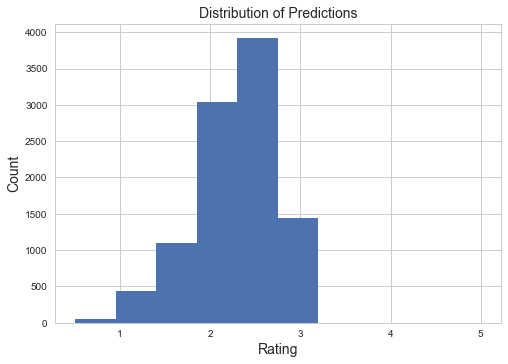

In [89]:
user_set = mx.nd.array((valid_users.astype('float32')))
movie_set = mx.nd.array((valid_movies.astype('float32')))

y_pred = model2(user_set, movie_set).asnumpy().argmax(axis=1)
y_pred = (y_pred + 1.) / 2

plt.title("Distribution of Predictions", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Rating", fontsize=14)
plt.hist(y_pred)
plt.show()

In [91]:
numpy.sqrt(((y_pred - valid_ratings) ** 2).mean())

1.6449065970184551

---
### T-SNE 그래프 그리기
---

- tensorboard를 이용하여 embedding된 영화값을 T-SNE로 그려봄

In [92]:
# tensorboard 및 sne 관련 셋팅
from tensorflow.contrib.tensorboard.plugins import projector
import tensorflow as tf
import pandas as pd

tf.reset_default_graph()
LOG_DIR = './t_sne'

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

//anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
//anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [93]:
## 영화 메타정보 셋팅
# 1) 영화 메타 데이터 로드
movie_info = pandas.read_csv('./ml-latest-small/movies.csv', sep=',', usecols=(0, 1, 2))
print(movie_info.head())
# genres 중 가장 처음꺼만 추출
first_genre = pd.DataFrame(movie_info.genres.str.split('|',1).tolist(), columns=['first_genre','etc'])['first_genre']
first_genre.head()

movie_info_adj = pd.concat([movie_info, first_genre], axis = 1)
movie_info_adj.head()
movie_info_adj.movieId.max()
print(len(movie_info_adj)) # 영화 메타 총 길이

## 기존 Movie index에 mappingEmbedding layer의 latent factor 개수에 맞도록 영화 메타테이블 생성
print(len(movie_info_adj.movieId.unique())) # 영화 메타의 개수
print(movie_info_adj.movieId.max()) # 영화 index max
print(len(movie_ind_map)) # embedding layer 영화 index 개수

movie_info_adj = pd.merge(movie_ind_map, movie_info_adj, how='left', on='movieId')
print(len(movie_info_adj))
movie_info_adj.head()
# movie_ind = pd.DataFrame(np.arange(1,movie_num+1), columns=['movieId'])
# movie_info_adj = pd.merge(movie_ind,movie_info_adj, how = 'left', on = 'movieId')
# movie_info_adj = movie_info_adj.fillna('')
# movie_info_adj.head()

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
9125
9125
164979
9066
9066


,movieId_ind,movieId,title,genres,first_genre
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure
2,2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy
4,4,5,Father of the Bride Part II (1995),Comedy,Comedy


In [94]:
## tensorborad의 meta파일 형식인 tsv로 변환
with open(LOG_DIR + '/movie_meta.tsv', 'w') as f:
    f.write('{}\t{}\t{}\n'.format('movieId_ind', 'title', 'first_genre'))
    for i in range(len(movie_info_adj)):
        c = movie_info_adj.iloc[i,:].tolist()
        f.write('{}\t{}\t{}\n'.format(c[0], c[2], c[4]))

In [95]:
# 학습된 embedding 값 추출 및 tf.variable로 변환
user_emb = model.user.weight.data().asnumpy()
print(user_emb.shape)

movie_emb = model.movie.weight.data().asnumpy()
print(movie_emb.shape)

movie_emb_tf = tf.convert_to_tensor(movie_emb)
print(movie_emb_tf)

with tf.device("/cpu:0"):
    movie_emb_tf = tf.Variable(movie_emb, trainable=False, name='movie_embedding')

writer = tf.summary.FileWriter(LOG_DIR)

(671, 25)
(9066, 25)
Tensor("Const:0", shape=(9066, 25), dtype=float32)


In [96]:
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = movie_emb_tf.name
# embedding.metadata_path = LOG_DIR + '/movie_meta.tsv'

projector.visualize_embeddings(writer, config)

In [97]:
# start tensorflow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR + '/deep_mf_model.ckpt'), 1000)

'./t_sne/deep_mf_model.ckpt-1000'

In [98]:
mov_meta = pandas.read_csv('./t_sne/movie_meta.tsv', sep='\t')

In [99]:
mov_meta.head()

,movieId_ind,title,first_genre
0,0,Toy Story (1995),Adventure
1,1,Jumanji (1995),Adventure
2,2,Grumpier Old Men (1995),Comedy
3,3,Waiting to Exhale (1995),Comedy
4,4,Father of the Bride Part II (1995),Comedy


#### Movie Embedding값의 T-SNE값 결과
![Embedding_T_SNE](Embedding_T_SNE.png)